### This notebook fits a BERTopic model to the data set and creates topic visualisations.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

import nltk

nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk import TweetTokenizer
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/garethsmith/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Run these two lines to have all plots appear on GitHub (do not run to use interactive plots within this notebook):
import plotly.io as pio

pio.renderers.default = "png"

In [2]:
# Set directory and file paths
READ_DIR = "../data/processed"

FILENAME = "twitter_airline_sentiment_cleaned_emoji_urls_html_symbols@#_quotes_currency_whitespace"

EMBEDDING_MPNET = "twitter_airline_sentiment_cleaned_emoji_urls_html_symbols@#_quotes_currency_whitespace_all-mpnet-base-v2.npy"

In [4]:
# Load embeddings
embeddings_mpnet = np.load(f"{READ_DIR}/{EMBEDDING_MPNET}")

In [5]:
# Load text data
df = pd.read_csv(f"{READ_DIR}/{FILENAME}.csv")

#### Set customisable parameters for BERTopic components:

In [6]:
# Parameters for UMAP
n_neighbors = 15
n_components = 5
min_dist = 0.1
metric_umap = "cosine"
random_state = 0

# UMAP model
reducer = UMAP(
    n_neighbors=n_neighbors,
    n_components=n_components,
    min_dist=min_dist,
    metric=metric_umap,
    random_state=random_state,
)

# Parameters for HDBScan
min_cluster_size = 15
min_samples = 5
metric_hdbscan = "euclidean"
cluster_selection_method = "eom"

# HDBScan model
clusterer = HDBSCAN(
    min_cluster_size=min_cluster_size,
    min_samples=min_samples,
    metric=metric_hdbscan,
    cluster_selection_method=cluster_selection_method,
    prediction_data=True,
)

# The lower and upper boundary of the range of n-values for different word n-grams
# or char n-grams to be extracted:
ngram_range = (1, 2)

#### Create functions to fit BERTopic model:

In [9]:
def get_bertmodel(ngram_range, umap_model, hdbscan_model):
    # Convert a collection of text documents to a matrix of token counts:
    vectorizer = CountVectorizer(
        stop_words=stopwords.words("english"),
        tokenizer=TweetTokenizer().tokenize,
        token_pattern=None,
        ngram_range=ngram_range,
    )

    # Fit BERTopic model with customisation:
    topic_model = BERTopic(
        vectorizer_model=vectorizer,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
    )

    return topic_model


def get_topics_probs(model, docs, embeddings):
    topics, probs = model.fit_transform(docs, embeddings=embeddings)
    return topics, probs


def fit_bert(docs, embeddings, ngram_range, umap_model, hdbscan_model):
    bertmodel = get_bertmodel(
        ngram_range=ngram_range, umap_model=umap_model, hdbscan_model=hdbscan_model
    )

    topics, probs = get_topics_probs(model=bertmodel, docs=docs, embeddings=embeddings)

    return bertmodel, topics, probs

#### Fit BERTopic model using MPNET embeddings:

In [10]:
bertmodel_mpnet, topics_mpnet, probs_mpnet = fit_bert(
    docs=list(df.clean_text),
    embeddings=embeddings_mpnet,
    ngram_range=ngram_range,
    umap_model=reducer,
    hdbscan_model=clusterer,
)

##### Display the results table:
note: Topic -1 represents outliers 

In [11]:
df_bertopics_mpnet = bertmodel_mpnet.get_topic_info()
print("Number of topics: {}".format(len(df_bertopics_mpnet)))
df_bertopics_mpnet["Percentage"] = round(
    df_bertopics_mpnet["Count"] / df_bertopics_mpnet["Count"].sum() * 100, 2
)
df_bertopics_mpnet

Number of topics: 125


,Topic,Count,Name,Representation,Representative_Docs,Percentage
0,-1,7039,-1_flight_get_cancelled_thanks,"[flight, get, cancelled, thanks, plane, im, us...","[about time! Thank you!, too Late Flight now, ...",48.79
1,0,1061,0_bag_luggage_bags_baggage,"[bag, luggage, bags, baggage, lost, claim, lef...",[Really... .you charge me $25 to check a bag a...,7.35
2,1,362,1_hold_call_phone_minutes,"[hold, call, phone, minutes, hours, hung, hour...",[Was put on hold for 5.5 hrs then got a call b...,2.51
3,2,274,2_great_crew_great flight_attendant,"[great, crew, great flight, attendant, thanks,...","[Great flight, as always! Thank you to the gre...",1.90
4,3,184,3_hold_cancelled_cancelled flightled_flightled,"[hold, cancelled, cancelled flightled, flightl...",[been on hold for an hour. I need to rebook my...,1.28
...,...,...,...,...,...,...
120,119,15,119_apply_team job_job opening_recruiting,"[apply, team job, job opening, recruiting, isi...",[i hope i get the opportunity to join the team...,0.10
121,120,15,120_connection_phl_help delayed_miss,"[connection, phl, help delayed, miss, layover,...",[can you help me with a delayed flight as im g...,0.10
122,121,15,121_credit_purchased_refunded_receipt,"[credit, purchased, refunded, receipt, yr, dat...",[- He Cancelled Flightled a flight & was given...,0.10
123,122,15,122_worst experience_experience ever_worst_eve...,"[worst experience, experience ever, worst, eve...",[this has to be the absolute WORST EXPERIENCE ...,0.10


#### Choose a topic number and print data from the corresponding row:

In [12]:
topic_num = 0
for i, v in df_bertopics_mpnet.iloc[topic_num + 1].items():
    print(f"{i} : {v}")

Topic : 0
Count : 1061
Name : 0_bag_luggage_bags_baggage
Representation : ['bag', 'luggage', 'bags', 'baggage', 'lost', 'claim', 'left', 'checked', 'baggage claim', 'carry']
Representative_Docs : ["Really... .you charge me $25 to check a bag and then you put it on a different flight... .still Don't have my bag!!!", 'on top or having to check my bag I had to wait over 30 min for my bag to come out at baggage claim. Thanks for wasting my time', 'WHERE IS MY BAG?']
Percentage : 7.35


#### Show topic words and c-TF-IDF scores:

In [13]:
bertmodel_mpnet.get_topic(0)

[('bag', 0.030781032981964496),
 ('luggage', 0.020684293552515522),
 ('bags', 0.020381819082489937),
 ('baggage', 0.01744777224381253),
 ('lost', 0.014214952302093903),
 ('claim', 0.00891830076154246),
 ('left', 0.0074704102380880755),
 ('checked', 0.006990550643813577),
 ('baggage claim', 0.0063810018291119005),
 ('carry', 0.006343575507500414)]

##### For each topic, we can observe the most important words, sorted in decreasing order based on the c-TF-IDF score:

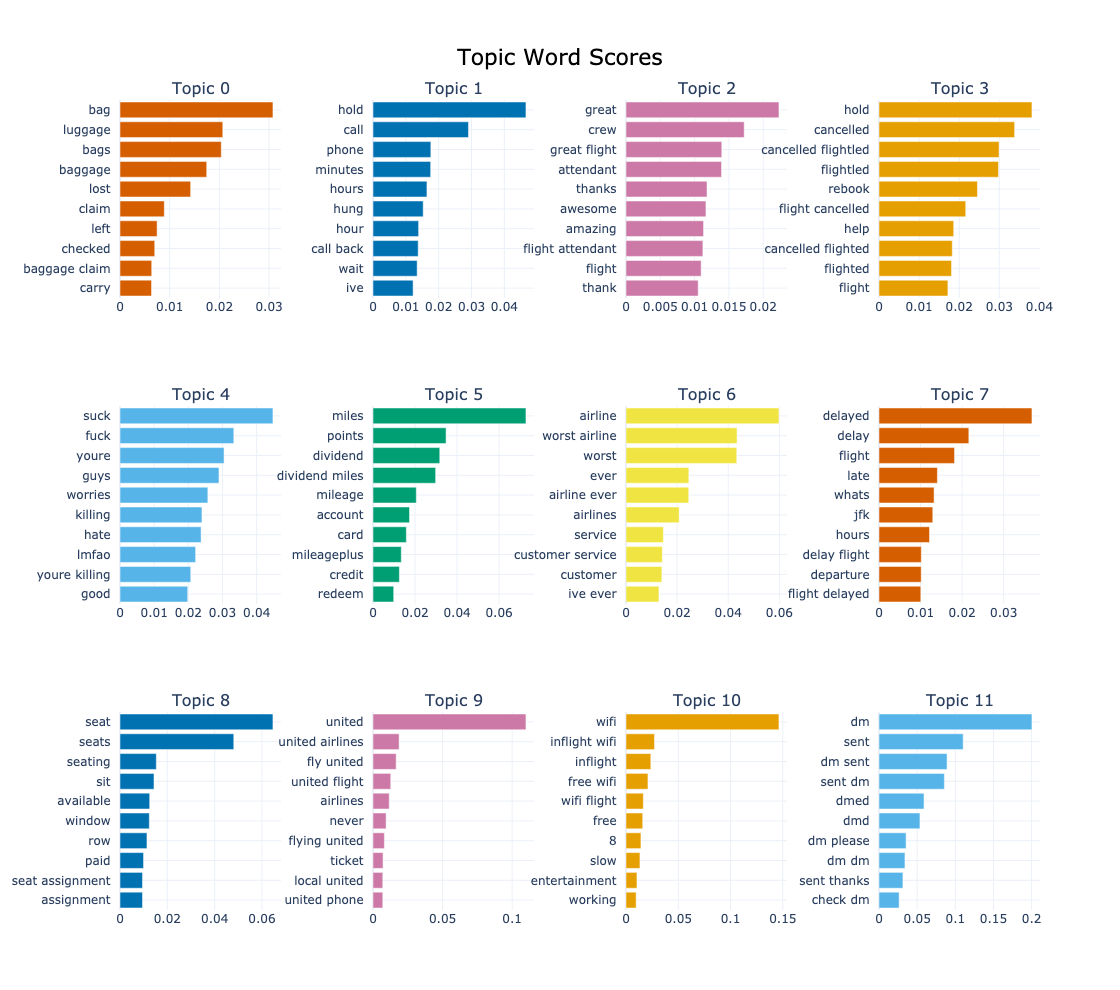

In [14]:
barchart = bertmodel_mpnet.visualize_barchart(
    width=280, height=330, top_n_topics=12, n_words=10
)
barchart.show()

### Looking at sample of outliers:

In [16]:
df_topics = pd.DataFrame(
    {"Document": df["clean_text"], "Topic": bertmodel_mpnet.topics_}
)

outlier_tweets = df_topics["Document"][df_topics["Topic"] == -1]

[print(tweet) for tweet in outlier_tweets.sample(15, random_state=11)]

Hi-My flight (BNA to LGA) was Cancelled Flighted this morning--. Looks like other flights out of BNA are taking off. Any chance?
And by the way, I'm planning it while I've Ben waiting in the line at customer service in PHX.. .for over an hour!
please please American call me so I can rebook ticket.
For my Grandma Ella's 80th, she would love a birthday greeting from your flight crew! She was a stewardess for Eastern Airlines.
... .you haven't got me just yet Can a 1 way LAX-NYC cost me under 190?
I missed a goal On because of your Inept male stewardess. I should have landed already but I havent taken off yet.
Any way that I can get a receipt for a Cancelled Flightled portion of a roundtrip flight? Used the flight voucher just need receipt.
no you are not, you just care about mighty dollar.
I'm on the flight, finally in the air. Not enough food to feed customers. No movie or entertainment on a 5 hr flight.
- That time when I spent a night trying to sleep in a toddler bed at the airport Ra

### Are there more topics about delays which could be merged?

In [17]:
df_topics["Topic"][df_topics["Document"].str.contains("delay")].value_counts()[:10]

Topic
-1     505
 7      84
 36     50
 0      44
 71     21
 33     20
 2      12
 18     12
 9      11
 26      9
Name: count, dtype: int64

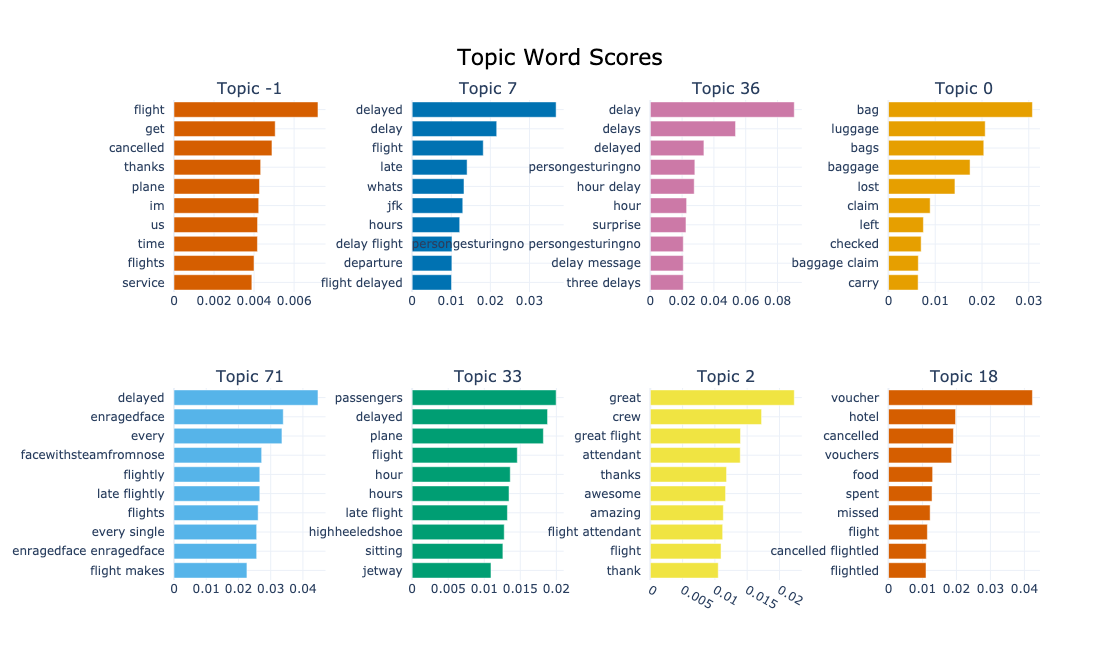

In [18]:
barchart = bertmodel_mpnet.visualize_barchart(
    width=280, height=330, topics=[-1, 7, 36, 0, 71, 33, 2, 18], n_words=10
)
barchart.show()

In [19]:
# Look at samples of the topics that appear to be most specifically about delays:
for topic in [7, 36, 71, 33]:
    [print(t) for t in bertmodel_mpnet.get_representative_docs(topic)]
    print()

Delayed: AA3186 - Missed due to delay: AA3186 - New flight now delayed: AA2401
what gives? Delayed over 2 hours at MCO to JFK. Every time!
is my flight delayed? It keeps changing between delayed and not??? If delayed is checkin time Late Flightr???

3 hour 45 min delay so far..... Would love to round to 4 hours to just go to bed!
it's not about the delay. It's about the communication.
while listening to a delay message on my phone, another delay message was coming in. Get your shit together!

18 flights so far this year. 13 delays including 2 Cancelled Flightations. Late Flightst reason, crew needed mandatory sleep. IN MEXICO!
every single time i fly you guys i am delayed at least 30 minutes. Every time. On flight 5612 out of to nola.
seriously? Every flight I have had the past 2 days has been delayed. Every single one. Terrible

Delayed 7 hrs flight 5721 PIT/IAD, finally board the plane, sit half hour & crew is at their hrs limit & we deplane. Unacceptable.
flight 623 den to phx: flig

In [22]:
# Look at more samples from topic 71
list(df_topics["Document"][df_topics["Topic"] == 71][:10])

['18 flights so far this year. 13 delays including 2 Cancelled Flightations. Late Flightst reason, crew needed mandatory sleep. IN MEXICO!',
 "can you not get the first flight of the day off the ground on time?. Let's go.......",
 'Every time my united flight got delayed. this is a big frustration.',
 'my flight is Late Flight due to mechanical issues 3 of 4 flights in past 10 days!',
 'never fails to have delayed flights enraged_face',
 ". being delayed 3 hours for a one hour flight is more than frustrating. I'm also unable to get a decent meal at this hour. Never again",
 "you know it's bad when you're praying your connecting flight is delayed because of an hour delay on the first flight",
 'Never can get a flight out on time. 4 hour delay earlier another hour delay on my connecting flight. Makes 10 straight delays',
 "be worse? oh you can't! delayed with no reason on the way to Lon;flight Cancelled Flighted with NO REASON less than 2 days before returning.",
 "thats because you didn

In [21]:
# Look at more samples from topic 33
list(df_topics["Document"][df_topics["Topic"] == 33][:10])

['2nd flight also delayed no pilots! But they boarded is so we can just sit here!',
 '4 passengers after a 2 hour delayed flight left with no hotel at the end of the night @ hou airport. Wtf??!!',
 "flight was scheduled for 11:56, it's 1:05 and we haven't moved. I have never been on a flight where everyone moved without a sense",
 "I'm aware of the flight details, thanks. Three hours Late Flight a crew that could not give less of a shit",
 "doesn't help the 100 or more passengers that just arrived an hour Late Flight.",
 "You suck. Flight delayed equipment probs again. Miss connection by 2 minutes and you won't let us on even though it's at the gate.",
 'Delayed 7 hrs flight 5721 PIT/IAD, finally board the plane, sit half hour & crew is at their hrs limit & we deplane. Unacceptable.',
 "unacceptable. 403 was 90 min Late Flight for a 'missing screw' our flight to Tucson left before we even landed",
 'leadership counts. landed at 11:15 last night-deplaned at 12:40. 45 minutes of that was

#### The above look to be mostly delay-oriented, so now to merge:

### Merging topics about delays:

In [23]:
topics_to_merge = [7, 36, 71, 33]
bertmodel_mpnet.merge_topics(df["clean_text"], topics_to_merge)

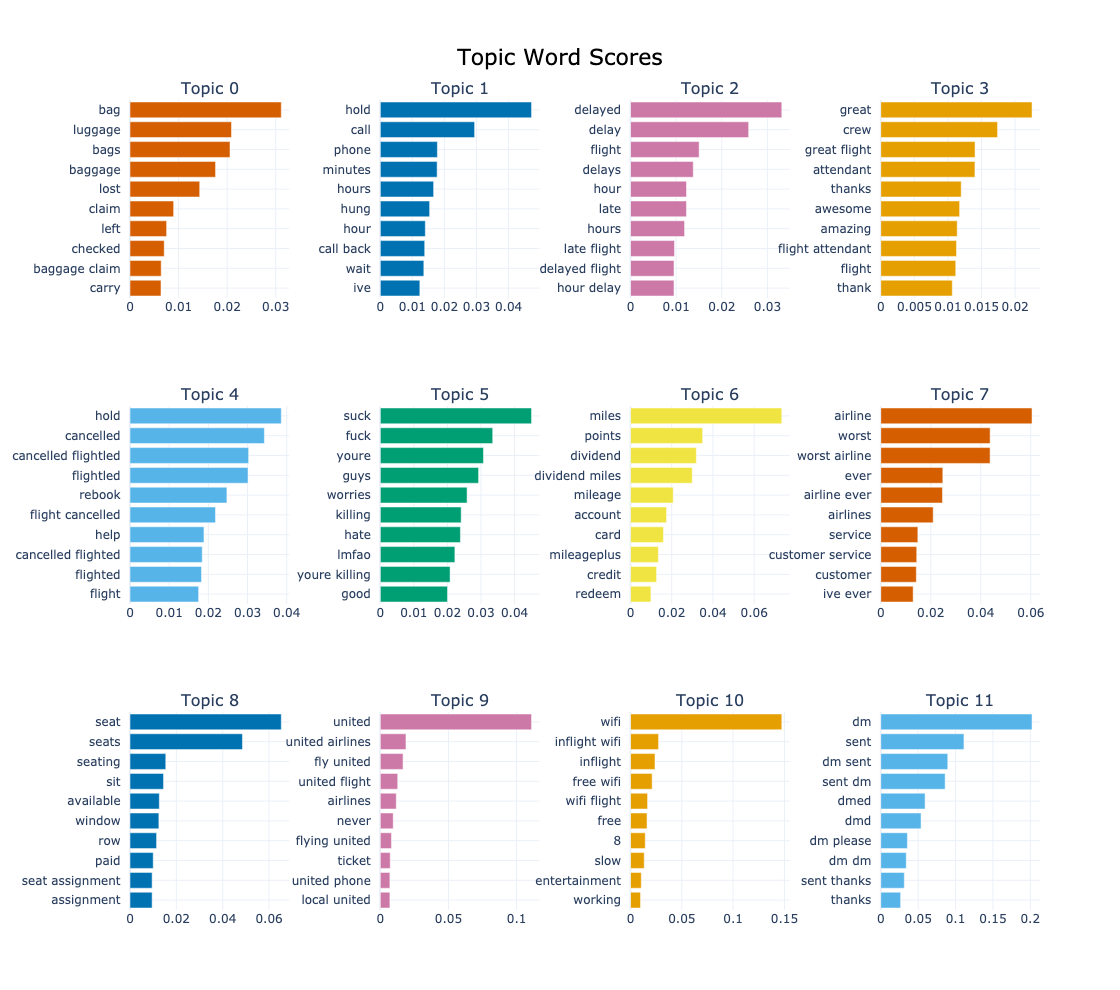

In [24]:
barchart = bertmodel_mpnet.visualize_barchart(
    width=280, height=330, top_n_topics=12, n_words=10
)
barchart.show()

#### We can also see the distribution of topics per class, i.e. per Airline in this case:

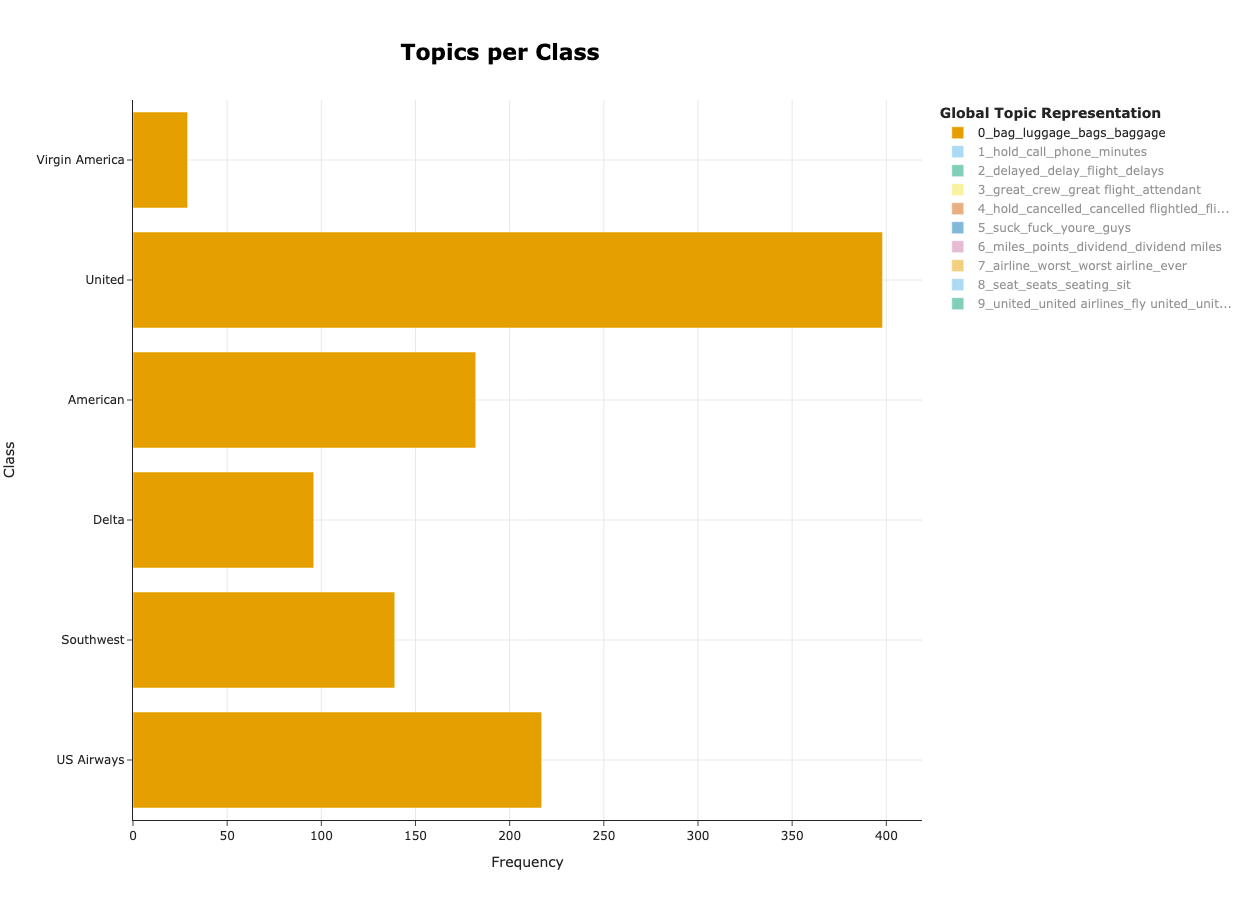

In [25]:
topics_per_class = bertmodel_mpnet.topics_per_class(
    df["clean_text"], classes=df["airline"]
)

bertmodel_mpnet.visualize_topics_per_class(
    topics_per_class, top_n_topics=10, normalize_frequency=False
)

## Look at document info table:

In [26]:
df_doc = bertmodel_mpnet.get_document_info(df["clean_text"])
df_doc["Airline"] = df["airline"]
df_doc.head()

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document,Airline
0,What said.,5,5_suck_fuck_youre_guys,"[suck, fuck, youre, guys, worries, killing, ha...","[YOU SUCK!, u guys suck, you guys suck!]",suck - fuck - youre - guys - worries - killing...,0.347695,False,Virgin America
1,plus you've added commercials to the experienc...,-1,-1_flight_get_cancelled_thanks,"[flight, get, cancelled, thanks, plane, im, us...","[about time! Thank you!, too Late Flight now, ...",flight - get - cancelled - thanks - plane - im...,0.000000,False,Virgin America
2,I didn't today... Must mean I need to take ano...,35,35_yes_would get_loading_baggage,"[yes, would get, loading, baggage, ticket agen...","[No! We departed 24 hours Late Flightr, with a...",yes - would get - loading - baggage - ticket a...,1.000000,False,Virgin America
3,"it's really aggressive to blast obnoxious ""ent...",16,16_customers_treat_business_treat customers,"[customers, treat, business, treat customers, ...",[I know one thing would NEVER treat their cust...,customers - treat - business - treat customers...,0.464403,False,Virgin America
4,and it's a really big bad thing about it,119,119_worst experience_experience ever_worst_eve...,"[worst experience, experience ever, worst, eve...",[this has to be the absolute WORST EXPERIENCE ...,worst experience - experience ever - worst - e...,1.000000,False,Virgin America


#### It would be useful to plot topic counts normalised by total tweets per airline, so we can see the prevalence of particular themes,<br> e.g. complaints as a fraction of total tweets. <br>
#### The dataset was scraped in a single month (February 2015), but how the data were scraped is not described in the source. Therefore, it is unclear how much of the total content on Twitter related to these operators is present. <br>
#### For the purpose of this investigation I will treat it as complete, but for real-world applications you would want to scrape all data related to a given set of operators over a long (possibly continuous) time period.

In [27]:
# Create a dictionary to map airline to total number of tweets associated
docs_per_airline = df["airline"].value_counts().to_dict()
docs_per_airline

{'United': 3805,
 'US Airways': 2906,
 'American': 2594,
 'Southwest': 2408,
 'Delta': 2211,
 'Virgin America': 503}

In [28]:
def plot_normalised_topics(
    data: pd.DataFrame,
    topics2plot: list[str],
    groupby_cols: list[str] = ["Topic", "Airline", "Name"],
    count_apply_col: str = "Airline",
    label_col: str = "Name",
    norm_dict: dict = docs_per_airline,
):
    """Function to plot normalised topic counts by a certain feature, e.g. count_apply_col = Airline"""
    df2plot = (
        data.groupby(groupby_cols)[count_apply_col].count().reset_index(name="Count")
    )
    df2plot_ = df2plot[df2plot["Topic"].isin(topics2plot)]
    df2plot_["Percentage"] = 100 * df2plot_.apply(
        lambda x: x["Count"] / norm_dict[x[count_apply_col]], axis=1
    )
    sns.barplot(df2plot_, x=count_apply_col, y="Percentage", hue=label_col).set_title(
        "Normalised topics"
    )
    plt.gcf().set_size_inches(12, 8)

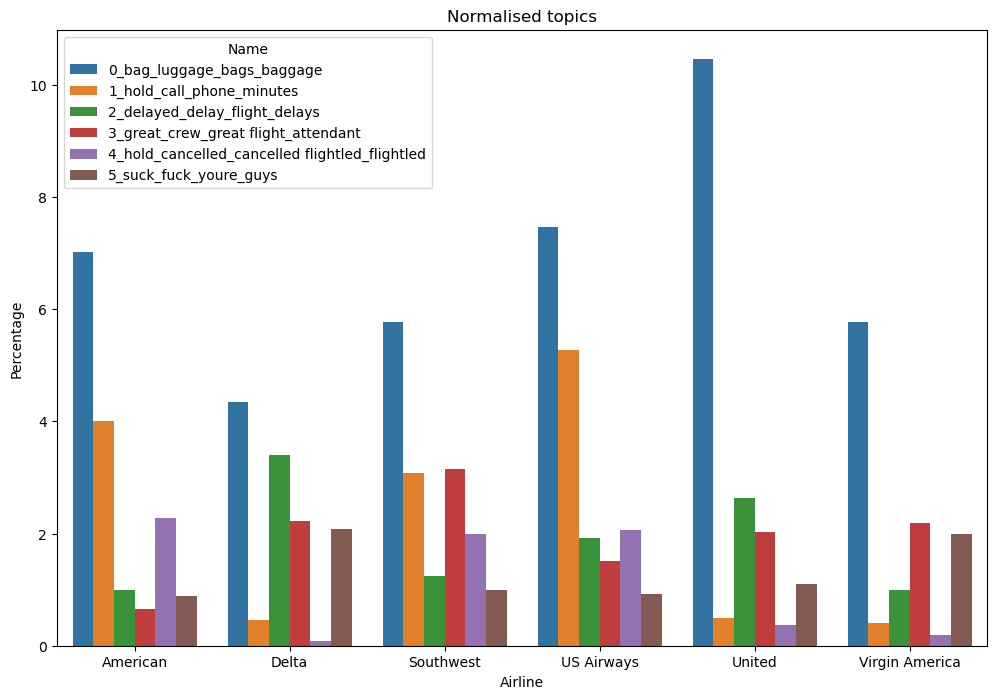

In [30]:
plot_normalised_topics(
    data=df_doc,
    topics2plot=[0, 1, 2, 3, 4, 5],
    groupby_cols=["Topic", "Airline", "Name"],
    count_apply_col="Airline",
    label_col="Name",
    norm_dict=docs_per_airline,
)

From the above, it appears that:
- United have the biggest issues related to baggage, although it's prevalent for all airlines
- American, Southwest and US Airways have siginificant issues related to being on hold on the phone
- Delta are most affected by delays
- Virgin America have the fewest problems with cancelled flights

In [31]:
# Print samples of the topics from above:
for topic in [0, 1, 2, 3, 4, 5]:
    [
        print(f"Topic {topic}: {t}")
        for t in bertmodel_mpnet.get_representative_docs(topic)
    ]
    print()

Topic 0: Really... .you charge me $25 to check a bag and then you put it on a different flight... .still Don't have my bag!!!
Topic 0: on top or having to check my bag I had to wait over 30 min for my bag to come out at baggage claim. Thanks for wasting my time
Topic 0: WHERE IS MY BAG?

Topic 1: Was put on hold for 5.5 hrs then got a call back at 11:20 pm, only to wait on hold for another hour.
Topic 1: been on hold for over and hour now.
Topic 1: Not good. On hold for over an hour.

Topic 2: now we are delayed until 1:02! This is ridiculous
Topic 2: Never can get a flight out on time. 4 hour delay earlier another hour delay on my connecting flight. Makes 10 straight delays
Topic 2: delayed to10.30!!

Topic 3: great flight! And great view!
Topic 3: Great flight, as always! Thank you to the great crew on flight 475!
Topic 3: Another great flight & crew, Las Vegas-Chicago. Thanks!

Topic 4: been on hold for 30 min trying to rebook my flight you Cancelled Flightled. Help?!
Topic 4: this 

#### Create a 2D representation of the topics:

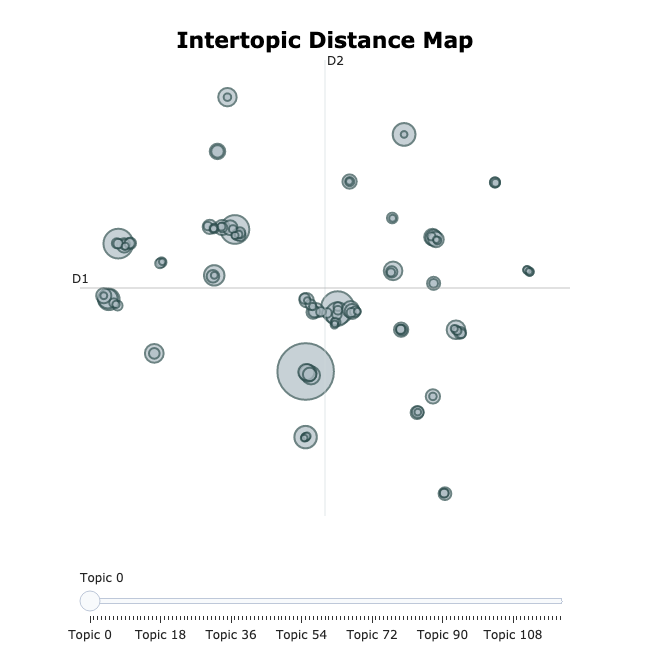

In [32]:
distance_map = bertmodel_mpnet.visualize_topics()
distance_map.show()

#### Visualise topic similarity with a heatmap:

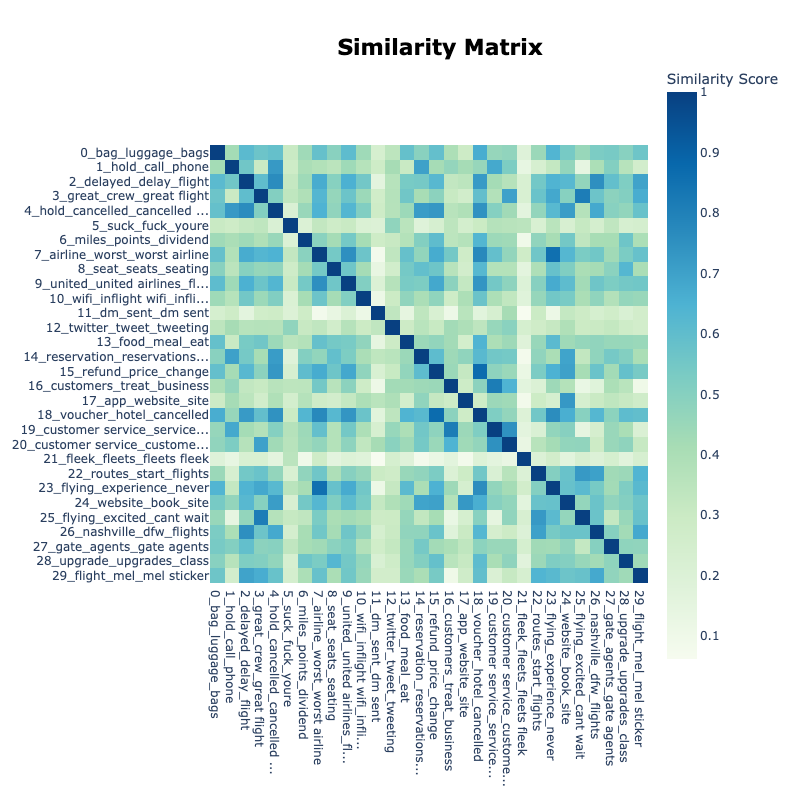

In [33]:
similarity_matrix = bertmodel_mpnet.visualize_heatmap(top_n_topics=30)
similarity_matrix.show()

#### We can also specify a number of clusters before creating the similarity matrix. Similar themes are then grouped together:

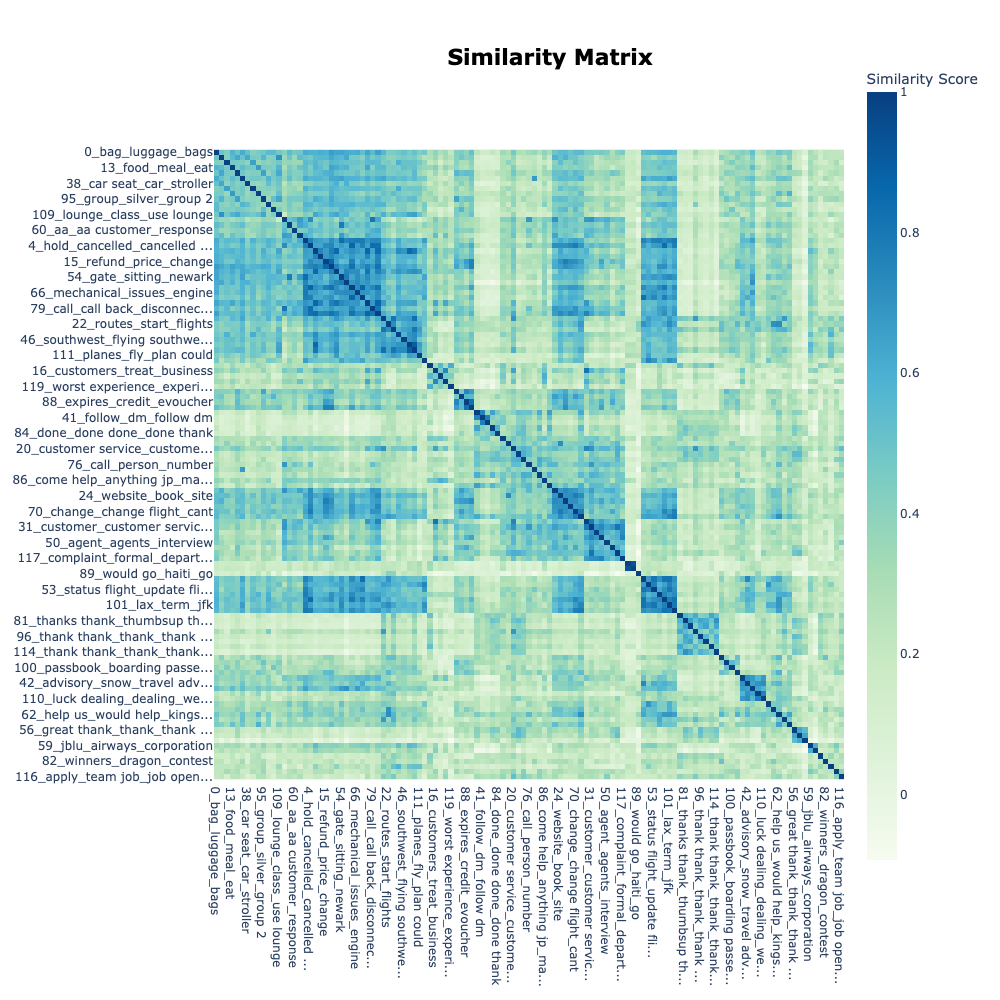

In [34]:
similarity_matrix = bertmodel_mpnet.visualize_heatmap(
    height=1000, width=1000, n_clusters=20
)
similarity_matrix.show()

#### Now visualise the documents within topics:

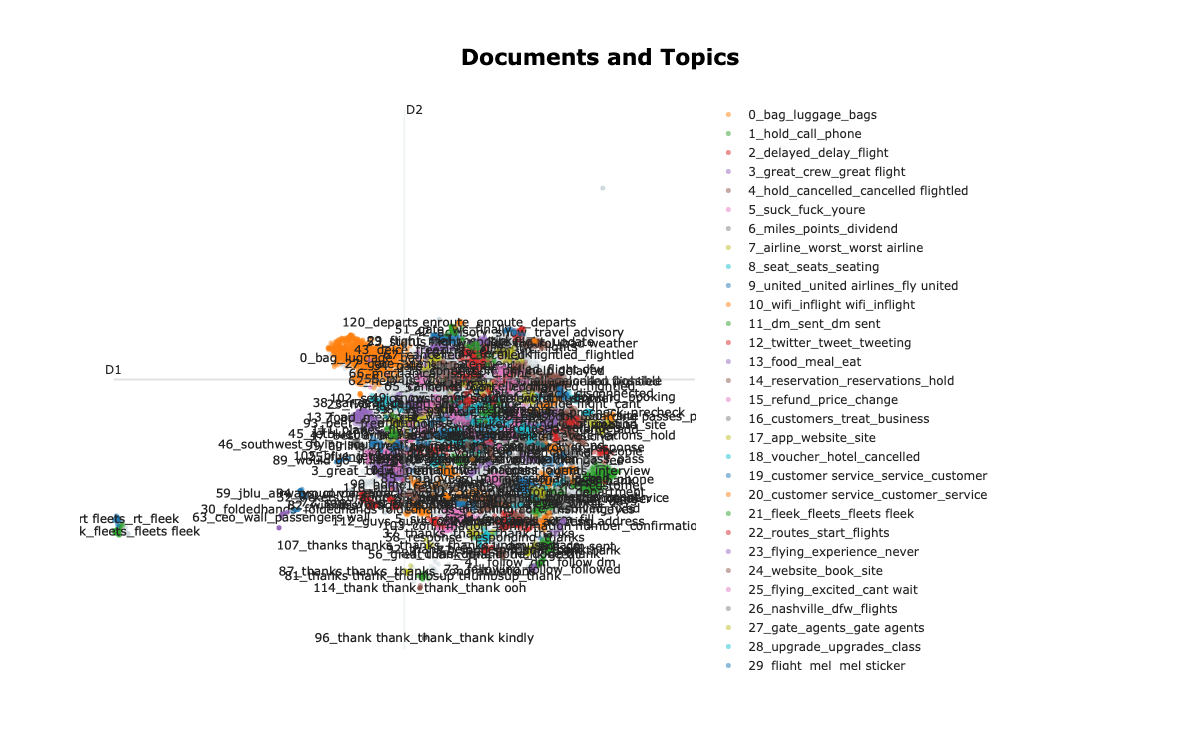

In [35]:
# Run the visualization with the original embeddings
# And viewing the original tweet text
bertmodel_mpnet.visualize_documents(docs=list(df.text), embeddings=embeddings_mpnet)

umap_vis = UMAP(
    n_neighbors=n_neighbors,
    n_components=2,
    min_dist=min_dist,
    metric=metric_umap,
    random_state=random_state,
)

# Reduce dimensionality of embeddings, this step is optional but much faster to perform iteratively:
reduced_embeddings = umap_vis.fit_transform(embeddings_mpnet)
bertmodel_mpnet.visualize_documents(
    docs=list(df.text), reduced_embeddings=reduced_embeddings
)

### Visualise with wordclouds

In [36]:
def create_wordcloud(topic_model, topic):
    text = {word: value for word, value in topic_model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Topic" + " " + str(topic))
    plt.show()

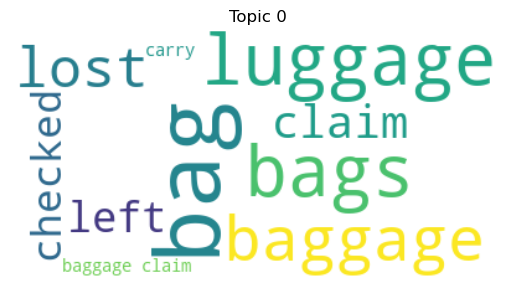

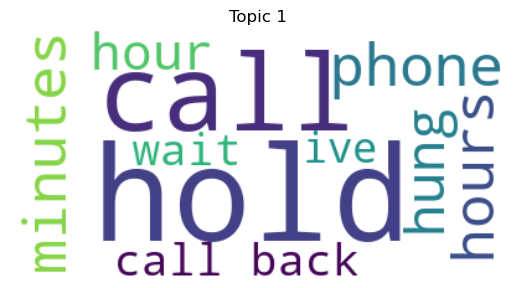

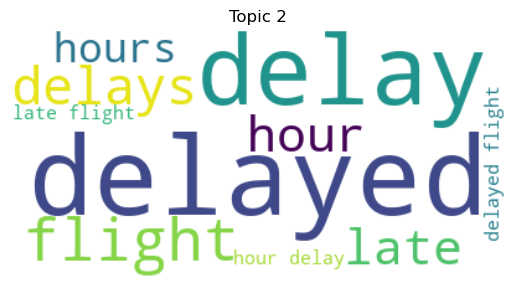

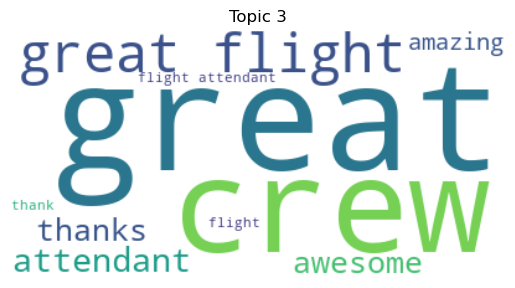

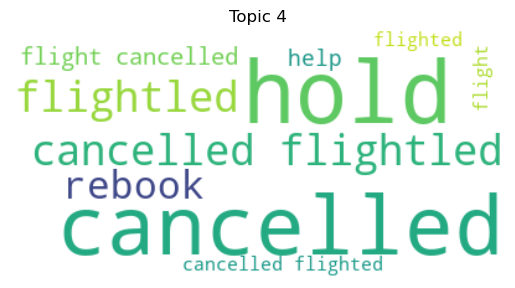

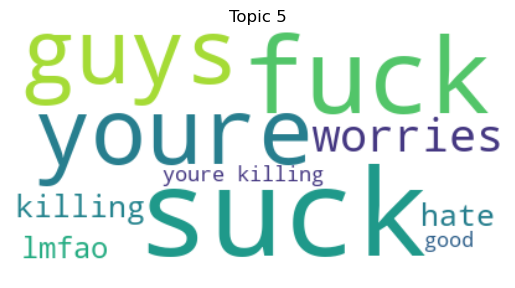

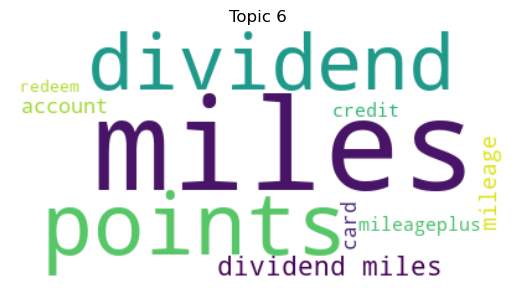

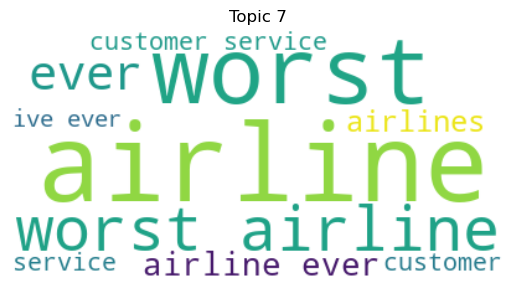

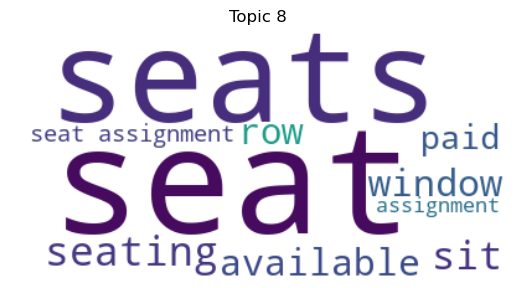

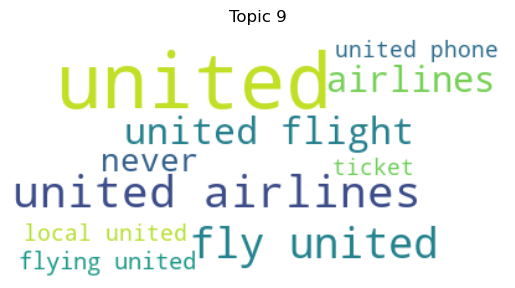

In [37]:
# Display the top 10 topics
for i in range(0, 10):
    create_wordcloud(bertmodel_mpnet, topic=i)

#### Save model:

In [38]:
# bertmodel_mpnet.save('../models/bertmodel_mpnet', save_embedding_model=True)
# bertmodel_mpnet.save('../models/bertmodel_mpnet_delay_merge', save_embedding_model=True)

#### To load:

In [8]:
# bertmodel_mpnet = BERTopic.load("../models/bertmodel_mpnet")
bertmodel_mpnet = BERTopic.load("../models/bertmodel_mpnet_delay_merge")